# Reservoir routines: LISFLOOD vs Hanazaki
***

**Author:** Chus Casado Rodríguez<br>
**Date:** 19-10-2023<br>

**Introduction:**<br>


**To do:**<br>
* [ ] Include evapotranspiration in the reservoir routine.
* [ ] The 20% that defines $V_e$ in the Hanazaki routine could be a calibration parameter.

In [1]:
import os
os.environ['USE_PYGEOS'] = '0'
import glob
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from pathlib import Path
import geopandas as gpd
import yaml
# from typing import Union, List, Tuple, Dict

from plots import reservoir_analysis
from reservoirs import Lisflood, Hanazaki

## Configuration

In [2]:
with open('config_extraction.yml', 'r', encoding='utf8') as ymlfile:
    cfg = yaml.load(ymlfile, Loader=yaml.FullLoader)

path_res = Path(cfg['path_res'])
path_ts = Path(cfg['path_ts'])
# path_out = Path(cfg['path_out'])
# if path_out.exists() is False:
#     path_out.mkdir()
# var = cfg['var']

path_datasets = Path('Z:/nahaUsers/casadje/datasets/')

# study period
start = cfg['period']['start']
end = cfg['period']['end']

# # config plots
# proj = ccrs.PlateCarree()
# extent = [-125, -67.5, 24, 51]

# plots will be saved in this path
path_out = Path('GloFAS')
if path_out.exists() is False:
    path_out.mkdir()

## Data

### GloFAS

#### Reservoirs

In [3]:
# load shapefile of GloFAS reservoirs
reservoirs = gpd.read_file('../data/reservoirs/GloFAS/GloFAS_reservoirs.shp') 
reservoirs.set_index('ResID', drop=True, inplace=True)
reservoirs.rename(columns={'stor': 'CAP_GLWD'}, inplace=True)

# select only those reservoirs included in ResOpsUS
resopsus = gpd.read_file('../GIS/reservoirs_GloFAS_ResOpsUS.shp')
resopsus.set_index('ResID', drop=True, inplace=True)
mask = reservoirs.index.intersection(resopsus.index)
reservoirs = reservoirs.loc[mask]
reservoirs.GRAND_ID = reservoirs.GRAND_ID.astype(int)

print(f'{reservoirs.shape[0]} reservoirs')

113 reservoirs


#### Time series

In [4]:
# read GloFAS time series
path = Path('../data/reservoirs/GloFAS/long_run')
glofas_ts = {}
for file in tqdm(glob.glob(f'{path}/*.csv')):
    id = int(file.split('\\')[-1].split('.')[0].lstrip('0'))
    if id not in reservoirs.index:
        continue
    glofas_ts[id] = pd.read_csv(file, parse_dates=True, dayfirst=False, index_col='date')
    
print(f'{len(glofas_ts)} reservoirs')

  0%|          | 0/143 [00:00<?, ?it/s]

107 reservoirs


In [5]:
# check if reservoirs are missing
missing_reservoirs = reservoirs.index.difference(glofas_ts)
if len(missing_reservoirs) > 0:
    print(f'{len(missing_reservoirs)} reservoirs were not simulated in LISFLOOD')
    print(*missing_reservoirs)
reservoirs.drop(missing_reservoirs, axis=0, inplace=True)

6 reservoirs were not simulated in LISFLOOD
68 179 185 197 296 323


In [6]:
# # normalize inflow/outflow by the non-damaging outflow
# for id, df in glofas_ts.items():
#     df[['inflow', 'outflow']] /= reservoirs.loc[id, 'ndq']

#### Model parameters

In [7]:
# load static map of reservoirs
glofas_raster = xr.open_dataset(path_res)['res']

# extract an array of reservoir ID
ids = reservoirs.index.to_list()

# xr.DataArrays of reservoir longitudes and latitudes
lon = xr.DataArray(np.nan, dims=['ResID'], coords={'ResID': ids})
lat = xr.DataArray(np.nan, dims=['ResID'], coords={'ResID': ids})
for id in tqdm(ids):
    cell = glofas_raster.where(glofas_raster == id, drop=True)
    lon.loc[dict(ResID=id)] = cell.lon.data[0]
    lat.loc[dict(ResID=id)] = cell.lat.data[0]
coords = xr.Dataset({'lon': lon, 'lat': lat})

# extract parameter values
for par in ['adjustNormalFlood', 'ReservoirRnormqMult']:
    # load parameter map
    da = xr.open_dataset(f'Z:/nahaUsers/casadje/GloFASv4/parameters/{par}_GloFASv40.nc')[par]
    # extract values for each reservoir
    reservoirs[par] = da.sel(lon=lon, lat=lat, method='nearest').drop(['lon', 'lat']).to_pandas()

  0%|          | 0/107 [00:00<?, ?it/s]

In [8]:
# adjust normal limit and outflow with the calibrated parameters
reservoirs['nlim_adj'] = reservoirs.nlim + reservoirs.adjustNormalFlood * (reservoirs.flim - reservoirs.nlim)
reservoirs['normq_adj'] = pd.concat((reservoirs.normq * reservoirs.ReservoirRnormqMult, reservoirs.minq + .01), axis=1).max(axis=1)

### GRanD
#### Reservoirs

The shapefile of reservoirs in the GRanD data set is loaded to extract only the reservoir capacity reported in it.

In [9]:
# load GRanD data set
path_GRanD = path_datasets / 'reservoirs/GRanD/v1_3/'
grand = gpd.read_file(path_GRanD / 'grand_dams_v1_3.shp')
grand.set_index('GRAND_ID', drop=True, inplace=True)
grand = grand.replace(-99, np.nan)

# add GRanD capacity to the reservoirs
reservoirs['CAP_GRAND'] = grand.loc[reservoirs.GRAND_ID, 'CAP_MCM'].values

### ResOpsUS
#### Time series

In [10]:
path_ResOps = Path(path_datasets / 'reservoirs' / 'ResOpsUS')

resops_ts = {}
for glofas_id in tqdm(reservoirs.index):
    # load timeseries
    grand_id = reservoirs.loc[glofas_id, 'GRAND_ID']
    series_id = pd.read_csv(path_ResOps / 'time_series_all' / f'ResOpsUS_{grand_id}.csv', parse_dates=True, index_col='date')
    # remove empty time series
    series_id = series_id.loc[start:end]#.dropna(axis=1, how='all')
    # remove duplicated index
    series_id = series_id[~series_id.index.duplicated(keep='first')]
    # save in dictionary
    resops_ts[glofas_id] = series_id

  0%|          | 0/107 [00:00<?, ?it/s]

In [11]:
# approximate the ResOpsUS reservoir capacity as the maximum value in the records
reservoirs['CAP_RESOPS'] = pd.Series({id: df.storage.max() for id, df in resops_ts.items()})

In [12]:
# convert storage from hm3 to m3
for id, df in resops_ts.items():
    df.storage *= 1e6

### Correct reservoir capacity

In [13]:
try:
    # import DataFrame with the fraction fill and the selected data source
    ff = pd.read_excel('fraction_fill.xlsx', index_col='ResID')
except:
    # create DataFrame with the fraction fill according to each data source
    ff = pd.DataFrame(columns=['GLOFAS', 'GRAND'], dtype=float)
    ff.index.name = 'ResID'
    for id in reservoirs.index:
        cap_resops, cap_glofas, cap_grand = reservoirs.loc[id, ['CAP_RESOPS', 'CAP_GLWD', 'CAP_GRAND']]
        if np.isnan(cap_resops):
            continue
        ff.loc[id, :] = cap_resops / cap_glofas, cap_resops / cap_grand
    # export
    ff.to_excel('fraction_fill.xlsx', index=True)

In [14]:
# define de capacity  ('CAP') as that of the most reliable source
reservoirs['CAP'] = np.nan
for id in reservoirs.index:
    if ff.loc[id, 'selection'] == 'GLOFAS':
        reservoirs.loc[id, 'CAP'] = reservoirs.loc[id, 'CAP_GLWD']
    elif ff.loc[id, 'selection']:
        reservoirs.loc[id, 'CAP'] = reservoirs.loc[id, 'CAP_GRAND']

In [15]:
# convert storage time series into volume
for id, df in glofas_ts.items():
    df.storage *= reservoirs.loc[id, 'CAP'] * 1e6

## Reservoir routines

### LISFLOOD

#### Dummy example

To get a grasp into the reservoir routine in LISFLOOD I will create a reservoir with dummy values and will use the `plot_routine` method to evaluate the outflow function included in LISFLOOD.

I have only come up with dummy values for the total capacity (`Vtot`), the maximum outflow (`Qmax`), the multiplier of the normal outflow (`par_Qn`), and the factor that modulates the width of the normal storage (`par_Vn`). The rest of the values are the default values used in GloFAS.

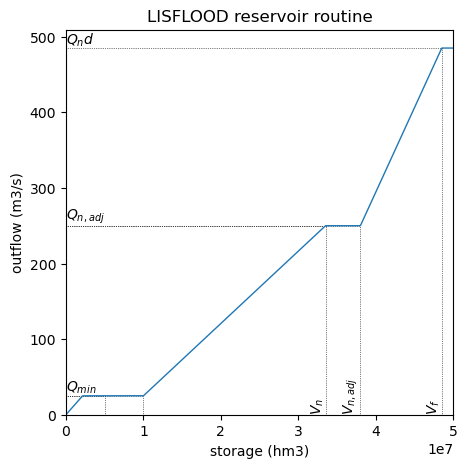

In [16]:
# dummy values
Vtot = 5e7
Qmax = 500
par_Qn = 1
par_Vn = .3

# volume limits (m3)
Vc = .1 * Vtot
Vn = .67 * Vtot
Vf = .97 * Vtot
Vn_adj = Vn + par_Vn * (Vf - Vn)

# outflow limits (m3/s)

Qmin = .05 * Qmax
Qn = .5 * par_Qn * Qmax
Qnd = .97 * Qmax

# declare the reservoir
dummy_lf = Lisflood(Vc, Vn, Vn_adj, Vf, Vtot, Qmin, Qn, Qnd)

# plot dummy routine
dummy_lf.plot_routine()

The LISFLOOD reservoir routine is a polyline with three/four rising limbs and three/two plateaus. The calibration only affects the width and height of the second plateau, i.e., the range of reservoir storage ($Q_n$, $Q_{n,adj}$) for which there is a constant release ($Q_{n,adj}$).

**Questions:**
* What's the use of the `Vc` value if then it is always multiplied by 2? Couldn't this multiplication be avoided and consider `Vc` as the 20% of the total capacity?
* What's the purpose of the plateau at `Qn`?

#### Real reservoir

Now I will repeat the analysis with a reservoir from GloFAS. First, I will plot the reference routine given the attributes of this reservoir in GloFAS.

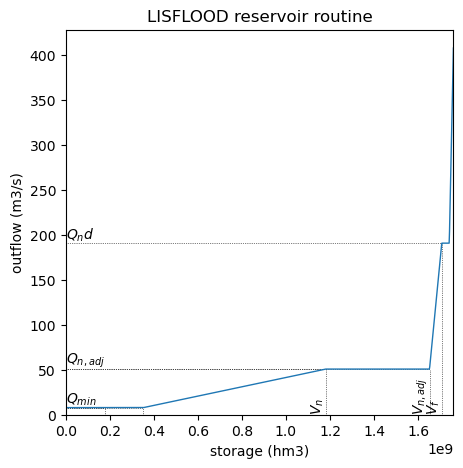

In [17]:
# GloFAS reservoir
ResID = 227

# storage limits
Vc, Vn, Vn_adj, Vf, Vtot = reservoirs.loc[ResID, ['clim', 'nlim', 'nlim_adj', 'flim', 'CAP']]
Vtot *= 1e6
Vc, Vn, Vn_adj, Vf = np.array([Vc, Vn, Vn_adj, Vf]) * Vtot

# outflow limits
Qmin, Qn, Qnd = reservoirs.loc[ResID, ['minq', 'normq_adj', 'ndq']]

# declare the reservoir
res_lf = Lisflood(Vc, Vn, Vn_adj, Vf, Vtot, Qmin, Qn, Qnd)

# plot dummy routine
res_lf.plot_routine()

##### Simulation

Now I will use the observed (ResOpsUS) and simulated (GloFAS4) inflow to the reservoir to simulate the evolution of both the reservoir storage and outflow with the LISFLOOD routine.

In [46]:
# observed and LISFLOOD simulated time series
obs = resops_ts[ResID][['storage', 'inflow', 'outflow']]
sim = glofas_ts[ResID][['storage', 'inflow', 'outflow']]

# normalize observed time series
obs_ = obs.copy()
obs_.storage /= res_lf.Vtot
obs_[['inflow', 'outflow']] /= res_lf.Qnd

**Simulation using as inflow the GloFAS data**

  0%|          | 0/13878 [00:00<?, ?it/s]

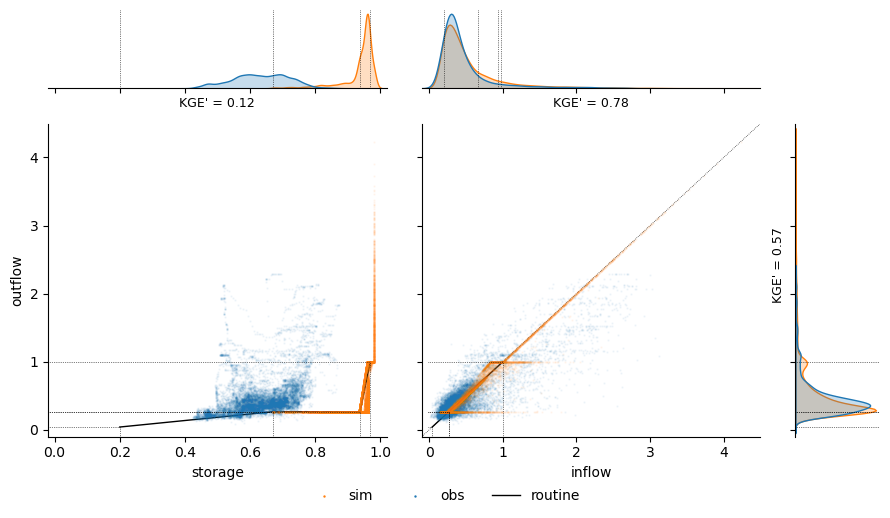

In [47]:
# simulate the reservoir
lsfld1 = res_lf.simulate(sim.inflow, obs.storage[0])

# analyse simulation
lsfld1_ = lsfld1.copy()
lsfld1_.storage /= res_lf.Vtot
lsfld1_[['inflow', 'outflow']] /= res_lf.Qnd

# analyse simuation
x_thr = np.array([2 * res_lf.Vc, res_lf.Vn, res_lf.Vn_adj, res_lf.Vf]) / res_lf.Vtot
y_thr = np.array([res_lf.Qmin, res_lf.Qn, res_lf.Qn, res_lf.Qnd]) / res_lf.Qnd
reservoir_analysis(lsfld1_, obs_, x_thr=x_thr, y_thr=y_thr)

The results match (at least in the broad sense) those obtained from the simulation of the LISFLOOD catchment model (reminder that here I'm running functions that I developed).

The simulated storage is very different from the observed timeseries ($KGE=0.12$). The simulated inflow approximates quite well the observations ($KGE=0.78$). The simulated outflow is still good ($KGE>0.5$), but the loss of performance compared with the inflow denotes that the routine does note reproduce the real behaviour of the reservoir.

To analyse this without the error introduced by the simulated reservoir inflow, I will repeat the simulation using the observed inflow time series.

**Simulation using as inflow the ResOpsUS records**

  0%|          | 0/13878 [00:00<?, ?it/s]

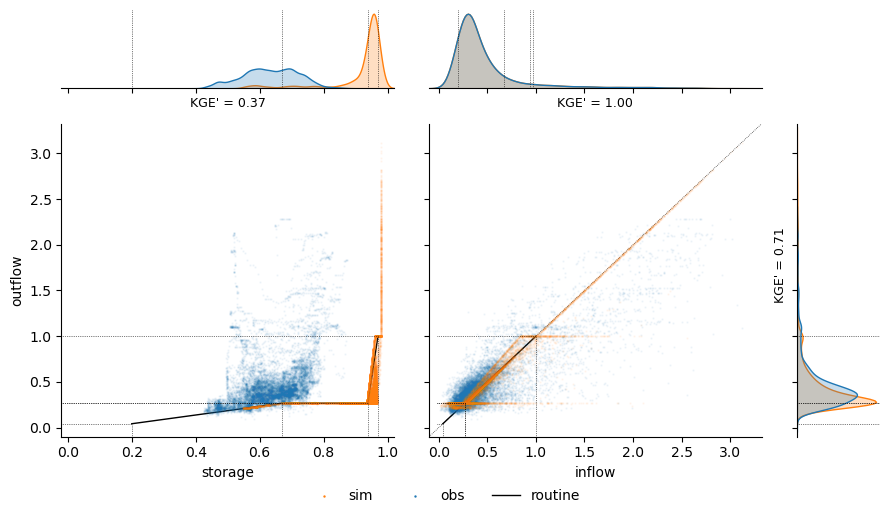

In [48]:
# simulate the reservoir
lsfld2 = res_lf.simulate(obs.inflow, obs.storage[0])

# normalize simulated time series
lsfld2_ = lsfld2.copy()
lsfld2_.storage /= res_lf.Vtot
lsfld2_[['inflow', 'outflow']] /= res_lf.Qnd

# analyse simulation
reservoir_analysis(lsfld2_, obs_, x_thr=x_thr, y_thr=y_thr)

When using the observed inflow as input, the simulated outflow has a very good performance ($KGE=0.71$), but all the loss in performance must be attributed to the reservoir routine, which means that there's ground for improvement. 

Ideas for improvement:
* The outflow distribution function shows two modes related to the normal and the flood outflows. These two values correspond to the plateaus in the routine. Do they make any sense?
* The storage limits are completely deviated from the observation. The reservoir tends to be almost full, when in reality the reservoir is mostly between 60-80% filling. Can we fit the storage limits based on records (when available) and regionalize these values to reservoirs that lack observations?

> **None**. What if I tune the reservoir parameters of the LISFLOOD routine. Can I improve at the same time the preformance in the simulation of storage and outflow? The following step would be to calibrate the reservoir with two target variables: outflow and storage.

**Rerun with customize parameters**

### Hanazaki

[Hanazaki et al. (2021)](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2021MS002944) developed a reservoir routine from that of Burek (LISFLOOD). The main differences are:
* The routine splits into two depending on the inflow, whether it exceeds the flood outflow or not.
* They introduce a release coefficient ($k$) that modulates the outflow under flood conditions ($I \ge Q_f$ and $V_f \le V \le V_e$).

#### Dummy example

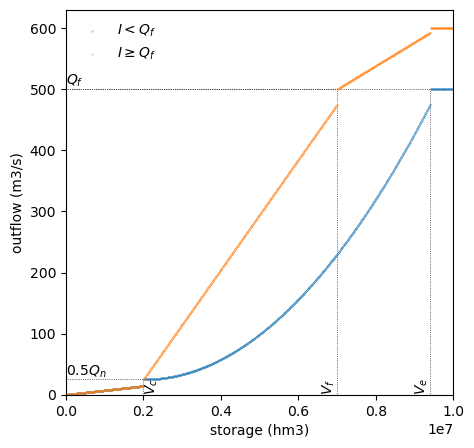

In [28]:
# volume limits (m3)
Vtot = 1e7
Vc = .2 * Vtot
Vf = .7 * Vtot
Ve = Vtot - .2 * (Vtot - Vf)

# outflow limits (m3/s)
Qn = 50
Qf = 500

# inflow (m3/s)
I = 1.1 * Qf

# release coefficient
k = .2

# catchment area (m2)
A = 200 * 1e6

# declare the reservoir
dummy_hnzk = Hanazaki(Vc, Vf, Ve, Vtot, Qn, Qf, A, )

# plot dummy routine
dummy_hnzk.plot_routine(modified=False)

The reservoir routine in Hanazaki's approach behaves differently depending on whether the inflow exceeds the flood outflow ($Q_f$)or not. 
* If the storage is below $V_c$, the routine is the same for both cases. The outflow is a linear function of storage specified by the pair of points [0, 0] and [$V_f$, $Q_n$]. At $V_c$ there's a jump in the outflow unless $\frac{V_c}{V_f}=0.5$.
* If the storage exceeds $V_c$, the reservoir behaves differently depending on the inflow:
    * If $I<Q_f$, the outflow is a quadratic function of the storage with two reference points: [$V_c$, $0.5 \cdot Q_n$], [$V_e$, $Q_f-0.5 \cdot Q_n$]. When the storage $V_e$ is reached, the outflow is fixed to $Q_f$. This approach has two jumps in the outflow: the previously mentioned jump at $V_c$ and another jump at $V_e$.
    * If $I \ge Q_f$, the outflow is a linear function of the storage. Up until $V_f$, the linear function has two supporting points: [$V_c$, $0.5 \cdot Q_n$], [$V_f$, $Q_f-0.5 \cdot Q_n$]. Between $V_f$ and $V_e$, the slope of the linear function depends on the $k$ release coefficient and the difference between the inflow and $Q_f$. When $V_e$ is exceeded, the outflow is equal to the inflow. This approach has up to three jumps: that at $V_c$ already mentioned, another at $V_f$, and a last one at $V_e$.
    
><font color='maroon'>**IDEA**</font>.Why are those breaks in the outflow function necessary? They could be avoided if the $0.5 \cdot Q_n$ term would be replaced by $\frac{V_c}{V_f} \cdot Q_n$, and if the term $\left(Q_f-Q_n\right)$ were replaced by $\left(Q_f - \frac{V_c}{V_f} \cdot Q_n\right)$

I have applied the previous idea and created a "modified" Hanazaki routine. Below a plot that shows the modified routine.

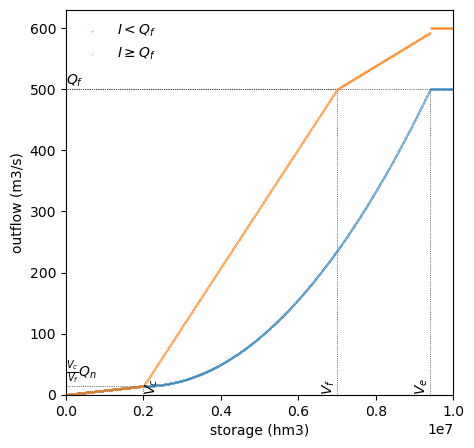

In [29]:
# plot dummy routine
dummy_hnzk.plot_routine(modified=True)

> **Note**. The break at $V_e$ when the inflow exceeds the flood outflow is caused by the release coefficient ($k=0.925$).

#### Real reservoir

Now I will test Hanazaki's routine with the same reservoir from ResOpsUS that I tested the LISFLOOD routine. Since in this case we do not have calibrated parameters to define the conservation ($V_c$) and flood storage ($V_f$), nor the normal ($Q_n$) and flood outflows ($Q_f$), I will define them as quantiles of the observed storage and inflow time series, respectively.

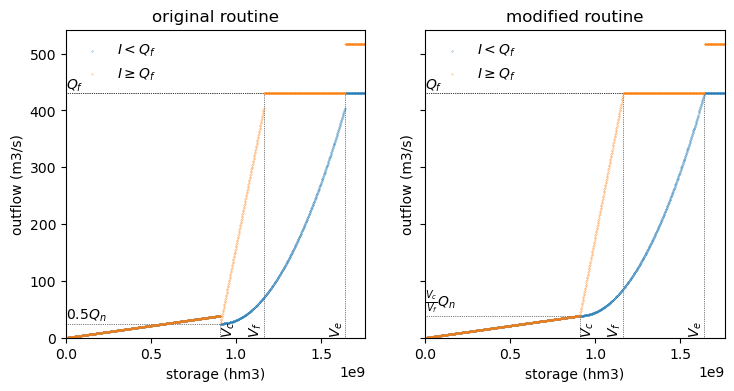

In [30]:
# GloFAS reservoir
ResID = 227

# storage limits (m3)
Vc = resops_ts[ResID].storage.quantile(.1)
Vf = resops_ts[ResID].storage.quantile(.6)
Vtot = reservoirs.loc[ResID, 'CAP'] * 1e6
Ve = Vtot - .2 * (Vtot - Vf)

# outflow limits
Qn = resops_ts[ResID].inflow.quantile(.25)
Qf = resops_ts[ResID].inflow.quantile(.99)

# catchment area (m2)
grand_id = reservoirs.loc[ResID, 'GRAND_ID'].astype(int)
A = grand.loc[grand_id, 'AREA_SKM'] * 1e6

# declare reservoir
res_hnzk = Hanazaki(Vc, Vf, Ve, Vtot, Qn, Qf, A)

# plot routines
fig, ax = plt.subplots(ncols=2, figsize=(8.5, 4), sharey=True)
res_hnzk.plot_routine(ax=ax[0], modified=False)
ax[0].set_title('original routine')
res_hnzk.plot_routine(ax=ax[1], modified=True)
ax[1].set_title('modified routine');

The left plot shows the original routine in Hanazaki's paper. As explained above, that routine has some breaks in the outflow function, which may not be realistic. The right plot shows a modification I've done on the routine so those breaks are removed.

##### Simulation

As in the LISFLOOD routine, I will use both the observed and simulated inflow time series as input to the Hanazaki routine. In both cases I will use the modified approach.

In [50]:
# observed and LISFLOOD simulated time series
obs = resops_ts[ResID][['storage', 'inflow', 'outflow']]
sim = glofas_ts[ResID][['storage', 'inflow', 'outflow']]

# normalize observed time series
obs_ = obs.copy()
obs_.storage /= res_hnzk.Vtot
obs_[['inflow', 'outflow']] /= res_hnzk.Qf

**Simulation using as inflow the GloFAS data**

  0%|          | 0/13878 [00:00<?, ?it/s]

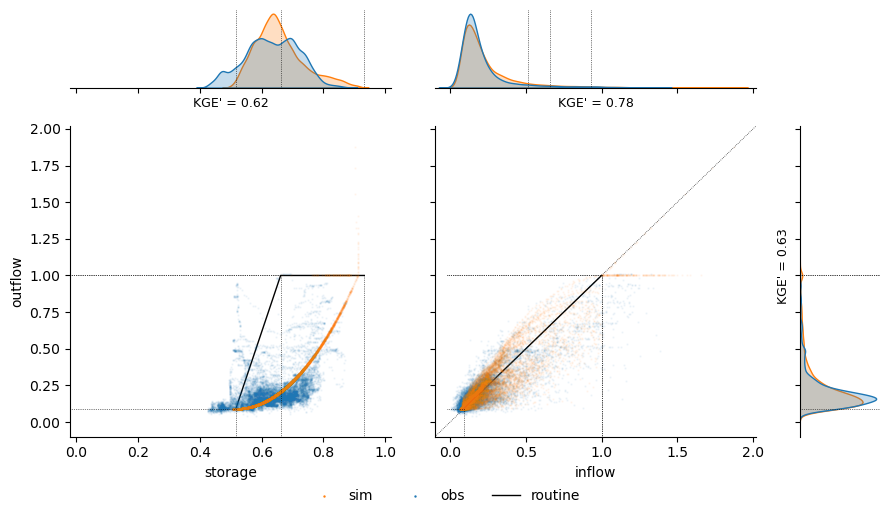

In [51]:
# simulate the reservoir
hnzk1 = res_hnzk.simulate(sim.inflow, obs.storage[0])

# normalize simulated time series
hnzk1_ = hnzk1.copy()
hnzk1_.storage /= res_hnzk.Vtot
hnzk1_[['inflow', 'outflow']] /= res_hnzk.Qf

# analyse simulation
x_thr = np.array([res_hnzk.Vc, res_hnzk.Vf, res_hnzk.Ve]) / res_hnzk.Vtot
y_thr = np.array([res_hnzk.Vc / res_hnzk.Vf * res_hnzk.Qn, res_hnzk.Qf, res_hnzk.Qf]) / res_hnzk.Qf
reservoir_analysis(hnzk1_, obs_, x_thr=x_thr, y_thr=y_thr)

First of all, the parameters I defined for the Hanazaki reservoirs were based in the observed distribution of storage and outflow, they are not random. Therefore, even if not calibrated parameters, they are a set of parameters based on some experience.

The Hanazaki simulation outperforms that from the LISFLOOD routine both in terms of outflow and storage. The improvement in outflow in marginal, but the improvement in terms of storage is huge (KGE of 0.62 instead of 0.12). The outflow KGE is still lower than that of inflow, which means that the routine losses some information. To quantify this loss I will rerun the model using as input inflow the observation.

**Simulation using as inflow the ResOpsUS records**

  0%|          | 0/13878 [00:00<?, ?it/s]

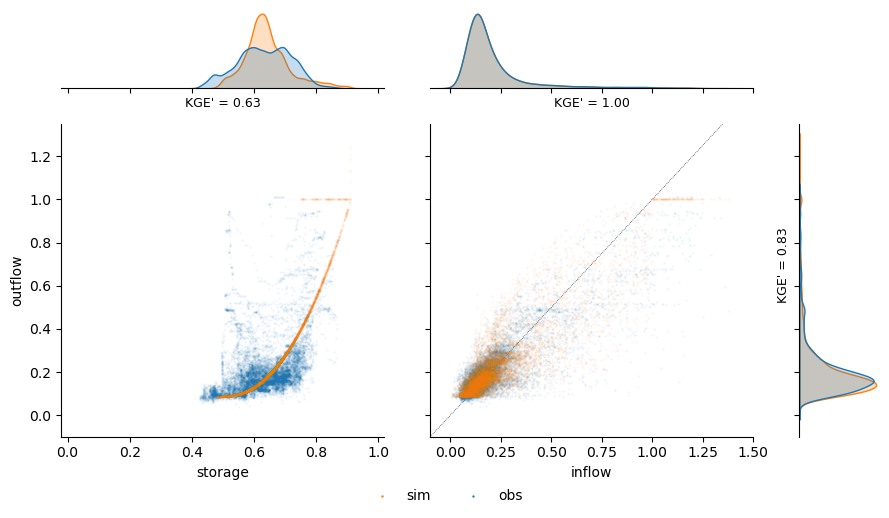

In [53]:
# simulate the reservoir
hnzk2 = res_hnzk.simulate(obs.inflow, obs.storage[0])

# normalize simulated time series
hnzk2_ = hnzk2.copy()
hnzk2_.storage /= res_hnzk.Vtot
hnzk2_[['inflow', 'outflow']] /= res_hnzk.Qf

# analyse simulation
reservoir_analysis(hnzk2_, obs_)#, x_thr=x_thr, y_thr=y_thr)

The results are similar, Hanazki's routine outpeforms LISFLOOD both in terms of outflow and storage. The storage KGE is almost equal when using observed or simulated inflows. The outflow KGE, instead, increases from 0.63 to 0.83; still, there's a loss of information in this routine.

In general, both routines simplify excesively the relation between storage and outflow. The scatter plots show that there is considerable dispersion between these two variables, whereas both routines approximate it by linear/quadratic functions. The fact that the Hanazaki routine has two different subroutines allos for a slight larger dispersion, but it still differs from the real reservoir functioning.